# Optotagging Analysis

## Tutorial overview

This Jupyter notebook will demonstrate how to analyze responses to optotagging stimuli in Neuropixels Brain Observatory datasets. Optotagging makes it possible to link _in vivo_ spike trains to genetically defined cell classes. By expressing a light-gated ion channel (in this case, ChR2) in a Cre-dependent manner, we can activate Cre+ neurons with light pulses delivered to the cortical surface. Units that fire action potentials in response to these light pulses are likely to express the gene of interest.

Of course, there are some shortcomings to this approach, most notably that the presence of light artifacts can create the appearance of false positives, and that false negatives (cells that are Cre+ but do not respond to light) are nearly impossible to avoid. We will explain how to deal with these caveats in order to incorporate the available cell type information into your analyses.

This tutorial will cover the following topics:

* <a href='#Finding-datasets-of-interest'>Finding datasets of interest</a>
* <a href='#Types-of-optotagging-stimuli'>Types of optotagging stimuli</a>
* <a href='#Aligning-spikes-to-light-pulses'>Aligning spikes to light pulses</a>
* <a href='#Identifying-Cre+-units'>Identifying Cre+ units</a>
* <a href='#Differences-across-genotypes'>Differences across genotypes</a>

This tutorial assumes you've already created a data cache, or are working with NWB files on AWS. If you haven't reached that step yet, we recommend going through the [data access tutorial](./ecephys_data_access.ipynb) first.

Functions related to analyzing responses to visual stimuli will be covered in other tutorials. For a full list of available tutorials, see the [SDK documentation](https://allensdk.readthedocs.io/en/latest/visual_coding_neuropixels.html).

First, let's deal with the necessary imports:

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

Next, we'll create an `EcephysProjectCache` object that points to a new or existing manifest file.

If you're not sure what a manifest file is or where to put it, please check out [this tutorial](./ecephys_data_access.ipynb) before going further.

In [2]:
# Example cache directory path, it determines where downloaded data will be stored
data_directory = '/local1/ecephys_cache_dir/'

manifest_path = os.path.join(data_directory, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## Finding datasets of interest

The `sessions` table contains information about all the experiments available in the `EcephysProjectCache`. The `full_genotype` column contains information about the genotype of the mouse used in each experiment.

In [3]:
sessions = cache.get_session_table()

sessions.full_genotype.value_counts()

wt/wt                                              30
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt      12
Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt     8
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt       8
Name: full_genotype, dtype: int64

About half the mice are wild type (`wt/wt`), while the other half are a cross between a Cre line and the Ai32 reporter line. The Cre mice express ChR2 in one of three interneuron subtypes: Parvalbumin-positive neurons (`Pvalb`), Somatostatin-positive neurons (`Sst`), and Vasoactive Intestinal Polypeptide neurons (`Vip`). We know that these genes are expressed in largely non-overlapping populations of inhibitory cells, and that, taken together, they [cover nearly the entire range of cortical GABAergic neurons](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3556905/#!po=8.92857), with the caveat that VIP+ cells are a subset of a larger group of 5HT3aR-expressing cells.

To find experiments performed on a specific genotype, we can filter the sessions table on the `full_genotype` column:

In [4]:
pvalb_sessions = sessions[sessions.full_genotype.str.match('Pvalb')]

pvalb_sessions

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
746083955,2019-10-03T00:00:00Z,726170935,brain_observatory_1.1,98.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,582,2216,6,"[VPM, TH, LGd, CA3, CA2, CA1, VISal, nan, grey..."
760345702,2019-10-03T00:00:00Z,739783171,brain_observatory_1.1,103.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,501,1862,5,"[MB, TH, PP, PIL, DG, CA3, CA1, VISal, nan, gr..."
773418906,2019-10-03T00:00:00Z,757329624,brain_observatory_1.1,124.0,F,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,546,2232,6,"[PPT, NOT, SUB, ProS, CA1, VISam, nan, APN, DG..."
797828357,2019-10-03T00:00:00Z,776061251,brain_observatory_1.1,107.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,611,2232,6,"[PPT, MB, APN, NOT, HPF, ProS, CA1, VISam, nan..."
829720705,2019-10-03T00:00:00Z,811322619,functional_connectivity,112.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,529,1841,5,"[SCig, SCop, SCsg, SCzo, POST, VISp, nan, CA1,..."
839557629,2019-10-03T00:00:00Z,821469666,functional_connectivity,115.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,450,1853,5,"[APN, NOT, MB, DG, CA1, VISam, nan, VISpm, LGd..."
840012044,2019-10-03T00:00:00Z,820866121,functional_connectivity,116.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,758,2298,6,"[APN, DG, CA1, VISam, nan, LP, VISpm, VISp, LG..."


The table above contains 8 sessions, 5 of which used the `brain_observatory_1.1` visual stimulus, and 3 of which used the `functional_connectivity` stimulus. Any experiments with the same stimulus set are identical across genotypes. Importantly, the optotagging stimulus does not occur until the end of the experiment, so any changes induced by activating a specific set of interneurons will not affect the visual responses that we measure.

## Types of optotagging stimuli

Let's load one of the above sessions to see how to extract information about the optotagging stimuli that were delivered.

In [5]:
session = cache.get_session_data(pvalb_sessions.index.values[-3])

The optotagging stimulus table is stored separately from the visual stimulus table. So instead of calling `session.stimulus_presentations`, we will use `session.optogenetic_stimulation_epochs` to load a DataFrame that contains the information about the optotagging stimuli:

In [6]:
session.optogenetic_stimulation_epochs

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9208.46044,a single square pulse,2.0,9208.46544,pulse,0.005
1,9210.64062,a single square pulse,1.7,9210.65062,pulse,0.010
2,9212.37064,2.5 ms pulses at 10 Hz,1.7,9213.37064,fast_pulses,1.000
3,9214.40076,2.5 ms pulses at 10 Hz,1.3,9215.40076,fast_pulses,1.000
4,9216.55091,2.5 ms pulses at 10 Hz,2.0,9217.55091,fast_pulses,1.000
...,...,...,...,...,...,...
295,9778.77516,2.5 ms pulses at 10 Hz,2.0,9779.77516,fast_pulses,1.000
296,9780.72530,half-period of a cosine wave,2.0,9781.72530,raised_cosine,1.000
297,9782.66528,a single square pulse,1.3,9782.67028,pulse,0.005


This returns a table with information about each optotagging trial. To find the unique conditions across all trials, we can use the following Pandas syntax:

In [7]:
columns = ['stimulus_name', 'duration','level']

session.optogenetic_stimulation_epochs.drop_duplicates(columns).sort_values(by=columns).drop(columns=['start_time','stop_time'])

,condition,level,stimulus_name,duration
id,,,,
3,2.5 ms pulses at 10 Hz,1.3,fast_pulses,1.000
2,2.5 ms pulses at 10 Hz,1.7,fast_pulses,1.000
4,2.5 ms pulses at 10 Hz,2.0,fast_pulses,1.000
17,a single square pulse,1.3,pulse,0.005
7,a single square pulse,1.7,pulse,0.005
0,a single square pulse,2.0,pulse,0.005
13,a single square pulse,1.3,pulse,0.010
1,a single square pulse,1.7,pulse,0.010
8,a single square pulse,2.0,pulse,0.010


The optotagging portion of the experiment includes four categories of blue light stimuli: 2.5 ms pulses delivered at 10 Hz for one second, a single 5 ms pulse, a single 10 ms pulse, and a raised cosine pulse lasting 1 second. All of these stimuli are delivered through a 400 micron-diameter fiber optic cable positioned to illuminate the surface of visual cortex. Each stimulus is delivered at one of three power levels, defined by the peak voltage of the control signal delivered to the light source, not the actual light power at the tip of the fiber.

Unfortunately, light power has not been perfectly matched across experiments. A little more than halfway through the data collection process, we switched from delivering light through an LED (maximum power at fiber tip = 4 mW) to a laser (maximum power at fiber tip = 35 mW), in order to evoke more robust optotagging responses. To check whether or not a particular experiment used a laser, you can use the following filter:

In [8]:
sessions.index.values >= 789848216

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

We realize that this makes it more difficult to compare results across experiments, but we decided it was better to improve the optotagging yield for later sessions than continue to use light levels that were not reliably driving spiking responses.

## Aligning spikes to light pulses

Aligning spikes to light pulses is a bit more involved than aligning spikes to visual stimuli. This is because we haven't yet created convenience functions for performing this alignment automatically, such as `session.presentationwise_spike_times` or `sesssion.presentationwise_spike_counts`. We are planning to incorporate such functions into the AllenSDK in the future, but for now, you'll have to write your own code for extracting spikes around light pulses (or copy the code below).

Let's choose a stimulus condition (10 ms pulses) and a set of units (visual cortex only), then create a DataArray containing binned spikes aligned to the start of each stimulus.

In [9]:
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

time_resolution = 0.0005 # 0.5 ms bins

bin_edges = np.arange(-0.01, 0.025, time_resolution)

def optotagging_spike_counts(bin_edges, trials, units):
    
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, trials, units)

We can use this DataArray to plot the average firing rate for each unit as a function of time:

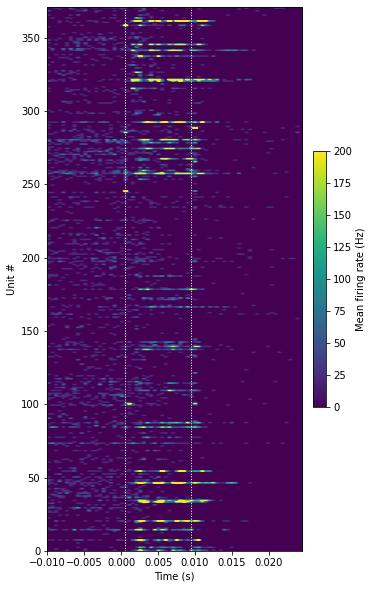

In [10]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))

    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(units)],
               aspect='auto', vmin=0, vmax=200)    

    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(units)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)

In this plot, we can see that a number of units increase their firing rate during the stimulus window, firing a burst of around three spikes. This is typical for Parvalbumin-positive neurons, which fire at high rates under natural conditions.

However, there are also some units that seem to fire at the very beginning and/or very end of the light pulse. These spikes are almost certainly artifactual, as it takes at least 1 ms to generate a true light-evoked action potential. Therefore, we need to disregard these low-latency "spikes" in our analysis.

## Identifying Cre+ units

Now that we know how to align spikes, we can start assessing which units are reliably driven by the optotagging stimulus and are likely to be Cre+.

There are a variety of ways to do this, but these are the most important things to keep in mind:
* Spikes that occur precisely at the start or end of a light pulse are likely artifactual, and need to be ignored.
* The bright blue light required for optotagging _can_ be seen by the mouse, so any spikes that occur more than 40 ms after the stimulus onset may result from retinal input, as opposed to direct optogenetic drive.
* The rate of false negatives (Cre+ cells that are not light-driven) will vary across areas, across depths, and across sessions. We've tried our best to evenly illuminate the entire visual cortex, and to use light powers that can drive spikes throughout all cortical layers, but some variation is inevitable.

For these reasons, we've found that the 10 ms pulses are the most useful stimulus for finding true light-evoked activity. These pulses provide a long enough artifact-free window to observe light-evoked spikes, but do not last long enough to be contaminated by visually driven activity.

Using the DataArray we created previously, we can search for units that increase their firing rate during the 10 ms pulse:

In [11]:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

Comparing the baseline and evoked rates, we can see a clear subset of units with a light-evoked increase in firing rate:

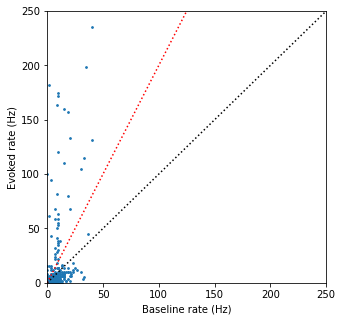

In [12]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 250
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

We can select a threshold, such as 2x increase in firing rate (red line) to find the IDs for units that are robustly driven by the light:

In [13]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors

cre_pos_units

array([951131472, 951131470, 951131486, 951131478, 951131522, 951131506,
       951131782, 951131534, 951131558, 951131556, 951131564, 951131560,
       951131581, 951131589, 951131583, 951131593, 951131612, 951131643,
       951131689, 951132054, 951132138, 951132140, 951132159, 951132184,
       951132212, 951132205, 951132224, 951132236, 951133681, 951133822,
       951133909, 951134030, 951134026, 951134066, 951134100, 951134199,
       951136071, 951136175, 951136247, 951136394, 951136657, 951136717,
       951136829, 951137028, 951137073, 951137204, 951140485, 951140617,
       951141942, 951140861, 951140832, 951140821, 951141065, 951141978,
       951141097, 951141154, 951141292, 951141373, 951141485, 951141536])

Because this is a Parvalbumin-Cre mouse, we expect the majority of light-driven units to be fast-spiking interneurons. We can check this by plotting the mean waveforms for the units we've identified.

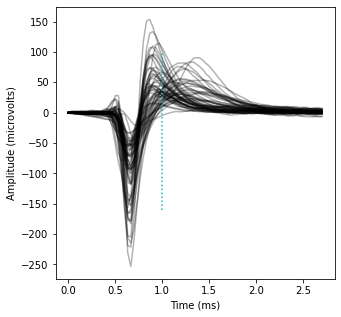

In [14]:
plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')

Indeed, most of these units have stereotypical "fast-spiking" waveforms (with a peak earlier than 1 ms). The outliers are likely parvalbumin-positive pyramidal cells.

## Differences across genotypes

The example above is a "best-case" scenario. As you look across experiments, you will find that there is substantial variability in the fraction of light-driven neurons. Some of this can be accounted for by differences in light power. But much of the variability can be attributed to genotype: parvalbumin+ cells are the most abundant type of inhibitory cells in the cortex, with somastatin+ cells coming next, and VIP+ cells a distant third. There are also likely differences in our ability to record from different interneuron subtypes. For example, parvalbumin+ cells generally fire at the highest rates, which makes them easier to detect in extracellular electrophysiology experiments. The size of the cell's soma also plays a role in its recordability, and this likely varies across interneuron sub-classes.

Overall, it is clear that VIP+ cells have proven the most difficult to identify through optotagging methods. The VIP-Cre mice we've recorded contain _very_ few light-driven units: the number is on the order of one per probe, and is sometimes zero across the whole experiment. We're not yet sure whether this is due to the difficultly of recording VIP+ cells with Neuropixels probes, or the difficulty of driving them with ChR2. To confounding things even further, VIP+ cells tend to have a _disinhibitory_ effect on the local circuit, so units that significantly increase their firing during the 1 s raised cosine light stimulus are not guaranteed to be Cre+.

In any case, it will be helpful to look at some characteristic examples of light-evoked responses in Sst-Cre and Vip-Cre mice, so you know what to expect.

In [15]:
sst_sessions = sessions[sessions.full_genotype.str.match('Sst')]

session = cache.get_session_data(sst_sessions.index.values[-1])

In [16]:
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

bin_edges = np.arange(-0.01, 0.025, 0.0005)

da = optotagging_spike_counts(bin_edges, trials, units)

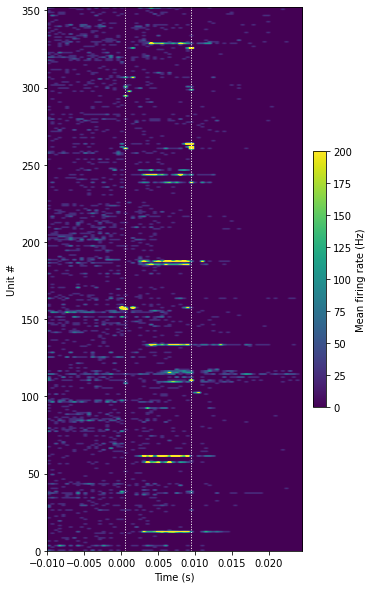

In [17]:
plot_optotagging_response(da)

In this Sst-Cre mouse, we see a smaller fraction of light-driven units than in the Pvalb-Cre mouse. The light-driven units tend to spike at a range of latencies following light onset, rather than displaying the rhythmic firing pattern of Parvalbumin+ cells. Again, note that the spikes that are precisely aligned to the light onset or offset are likely artifactual.

Now that we've computed the average responses, we can use the same method as above to find the units that are activated by the light.

In [18]:
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

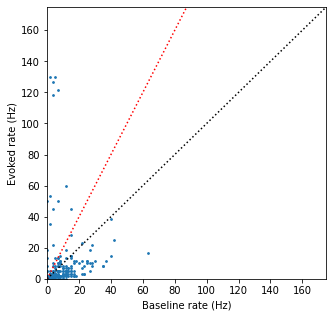

In [19]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 175
plt.plot([0,axis_limit],[0,axis_limit], ':k')
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')
plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

There are a smaller fraction of light-driven units in this Sst-Cre mouse, but the effect of optogenetic stimulation is still obvious. Let's look at the waveforms for the units that increase their firing rate at least 2x above baseline:

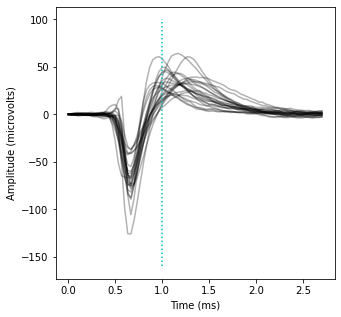

In [20]:
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values

plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
_ =plt.plot([1.0, 1.0],[-160, 100],':c')

As expected, we see a mix of fast-spiking and regular-spiking waveforms, in contrast to the primarily fast-spiking waveforms of the Parvalbumin+ units.

Now, let's take a look at light-evoked activity in a VIP-Cre mouse:

In [21]:
vip_sessions = sessions[sessions.full_genotype.str.match('Vip')]

session = cache.get_session_data(vip_sessions.index.values[-1])

In [22]:
trials = session.optogenetic_stimulation_epochs[(session.optogenetic_stimulation_epochs.duration > 0.009) & \
                                                (session.optogenetic_stimulation_epochs.duration < 0.02)]

units = session.units[session.units.ecephys_structure_acronym.str.match('VIS')]

bin_edges = np.arange(-0.01, 0.025, 0.0005)

da = optotagging_spike_counts(bin_edges, trials, units)

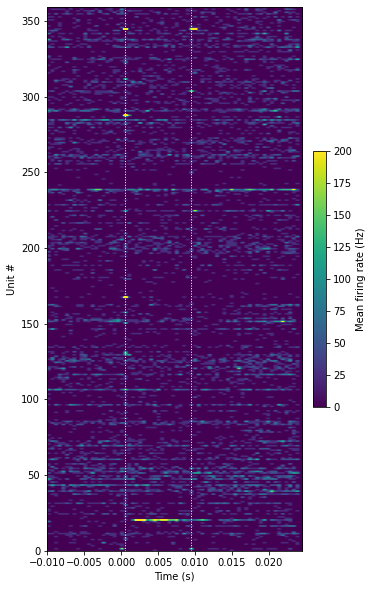

In [23]:
plot_optotagging_response(da)

This response looks much different than the examples above. There is only one unit (out of more than 350 in cortex) that is obviously responding to the 10 ms light pulse. Even though the yield for VIP-Cre mice is extremely low, these units will be extremely valuable to analyze. If we can characterize the stereotypical firing patterns displayed by labeled VIP+ interneurons, we may be able to identify them in unlabeled recordings.